## Depth Anything: Unleashing the Power of Large-Scale Unlabeled Data

[Link to paper](https://arxiv.org/abs/2401.10891)

### Loading Model

In [1]:
%matplotlib widget
%matplotlib inline

import cv2
import torch
import requests
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from io import BytesIO
from torchvision.transforms import Compose

from depth_anything.dpt import DepthAnything
from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet

def get_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    return np.array(img)

In [2]:
encoder = 'vits' # can also be 'vitb' or 'vitl'

transform = Compose([
    Resize(
        width=518,
        height=518,
        resize_target=False,
        keep_aspect_ratio=True,
        ensure_multiple_of=14,
        resize_method='lower_bound',
        image_interpolation_method=cv2.INTER_CUBIC,
    ),
    NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    PrepareForNet(),
])

depth_anything = DepthAnything.from_pretrained('LiheYoung/depth_anything_{:}14'.format(encoder)).eval()

xFormers not available
xFormers not available


### Image Inference

In [3]:
# img_url = "https://koitu.com/gallery/photos/IMG_20190310_185804.jpg"
img_url = "https://koitu.com/gallery/photos/PXL_20240118_062519789.jpg"
# img_url = "https://www.prints-online.com/p/164/exposition-universelle-internationale-paris-23439848.jpg"

img = get_image_from_url(img_url)
img = img / 255.0  # img values should be in range [0, 1]

In [4]:
%%time
image = transform({'image': img})['image']
image = torch.from_numpy(image).unsqueeze(0)

depth = depth_anything(image)  # depth shape: 1xHxW
depth = depth.detach().squeeze()

CPU times: user 5.85 s, sys: 2.39 s, total: 8.24 s
Wall time: 1.38 s


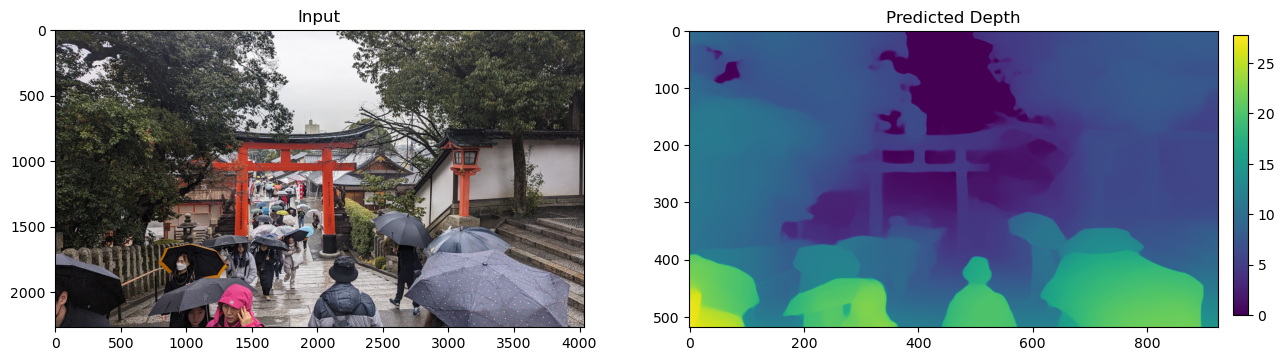

In [5]:
plt.figure(figsize=(15,7))

plt.subplot(121)
plt.title('Input')
plt.imshow(img)

plt.subplot(122)
plt.title('Predicted Depth')
plt.imshow(depth)

plt.colorbar(cax = plt.axes([0.91, 0.3, 0.01, 0.4]))

In [6]:
# np.save("kyoto_original.npy", img)
# np.save("kyoto_depth.npy", depth.numpy())

### Segmentation

In [7]:
from sklearn.cluster import KMeans

In [35]:
d = depth.numpy()
n, m = np.shape(d)

d = np.reshape(d, (n*m, 1))

k_means = KMeans(n_clusters=4)
k_means.fit(d)
res = k_means.predict(d)

res = np.reshape(res, (n,m))

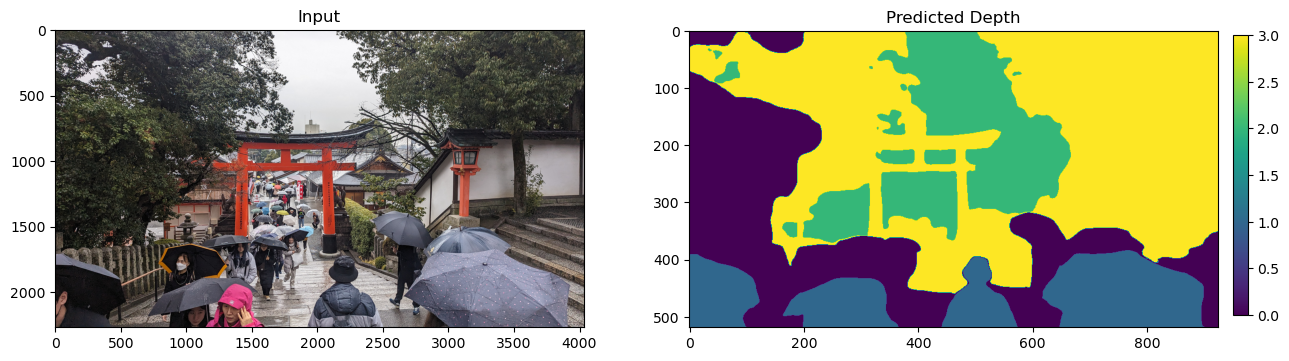

In [9]:
plt.figure(figsize=(15,7))

plt.subplot(121)
plt.title('Input')
plt.imshow(img)

plt.subplot(122)
plt.title('Predicted Depth')
plt.imshow(res)

plt.colorbar(cax = plt.axes([0.91, 0.3, 0.01, 0.4]))

These results seem pretty decent however the only information that k-means is using is the depth map so this method might only be good for getting some idea about how many layers would be appropriate for the tunnel book

In [10]:
from skimage.segmentation import slic, mark_boundaries
from skimage.transform import resize

# https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_segmentations.html
# https://scikit-image.org/docs/stable/auto_examples/transform/plot_rescale.html

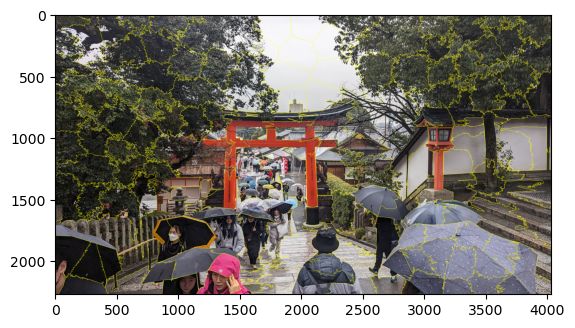

In [11]:
slic_segments_test = slic(img, n_segments=250, compactness=10, sigma=1, start_label=1)
plt.imshow(mark_boundaries(img, slic_segments_test))

In [12]:
d = depth.numpy()
n, m = d.shape
n_d = d / np.max(np.reshape(d, n * m))  # normalized to [0,1]

rescaled_img = resize(img, (n, m), anti_aliasing=True)

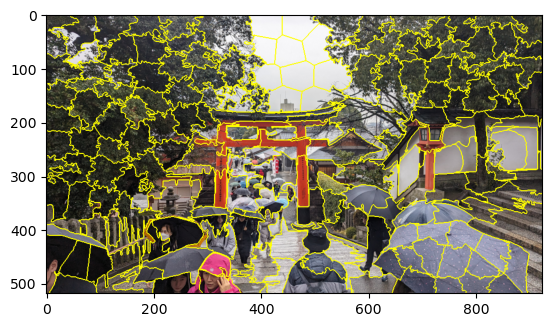

In [13]:
rgb_slic = slic(rescaled_img, n_segments=250, compactness=10, sigma=1, start_label=1)
plt.imshow(mark_boundaries(rescaled_img, rgb_slic))

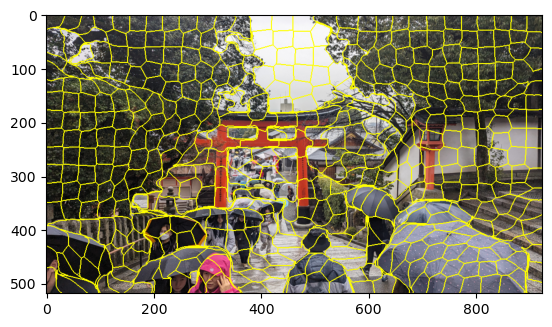

In [14]:
d_slic = slic(n_d, n_segments=500, compactness=0.03, sigma=1, start_label=1, channel_axis=None)
plt.imshow(mark_boundaries(rescaled_img, d_slic))

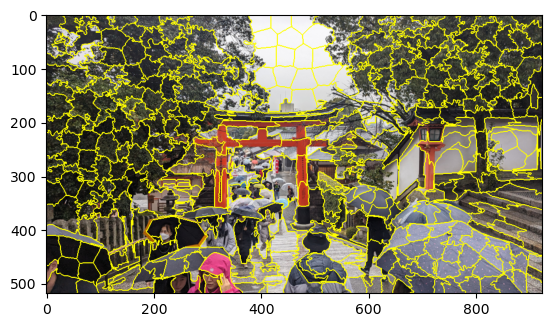

In [15]:
rgbd = np.zeros((n, m, 4))
rgbd[:,:,0:3] = rescaled_img
rgbd[:,:,3] = n_d

rgbd_slic = slic(rgbd, n_segments=500, compactness=0.1, sigma=1, start_label=1)
plt.imshow(mark_boundaries(rescaled_img, rgbd_slic))
# plt.imshow(segments_slic)

It does not appear that combining the depth information with the color information has made any real improvements...

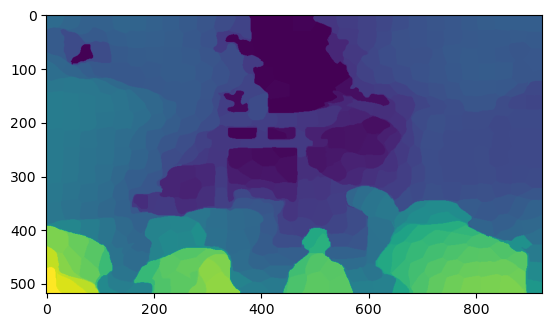

In [32]:
segment_ids = np.unique(d_slic)

masks = np.array([(d_slic == i) for i in segment_ids])
d_avgs = np.zeros((n, m), dtype='float')
for mk in masks:
    d_avgs[mk] = np.mean(n_d[mk])

plt.imshow(d_avgs)

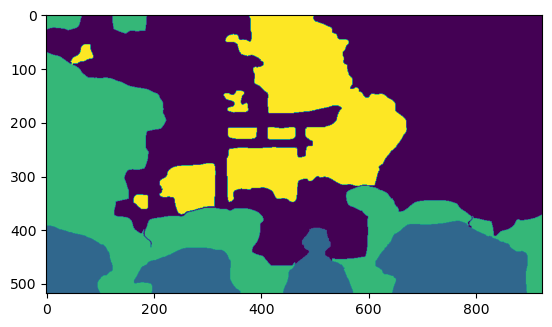

In [33]:
d = np.reshape(d_avgs, (n*m, 1))

k_means = KMeans(n_clusters=4)
k_means.fit(d)
d_avgs_kmeans = k_means.predict(d)

res = np.reshape(d_avgs_kmeans, (n,m))
plt.imshow(res)

(4, 518, 924)


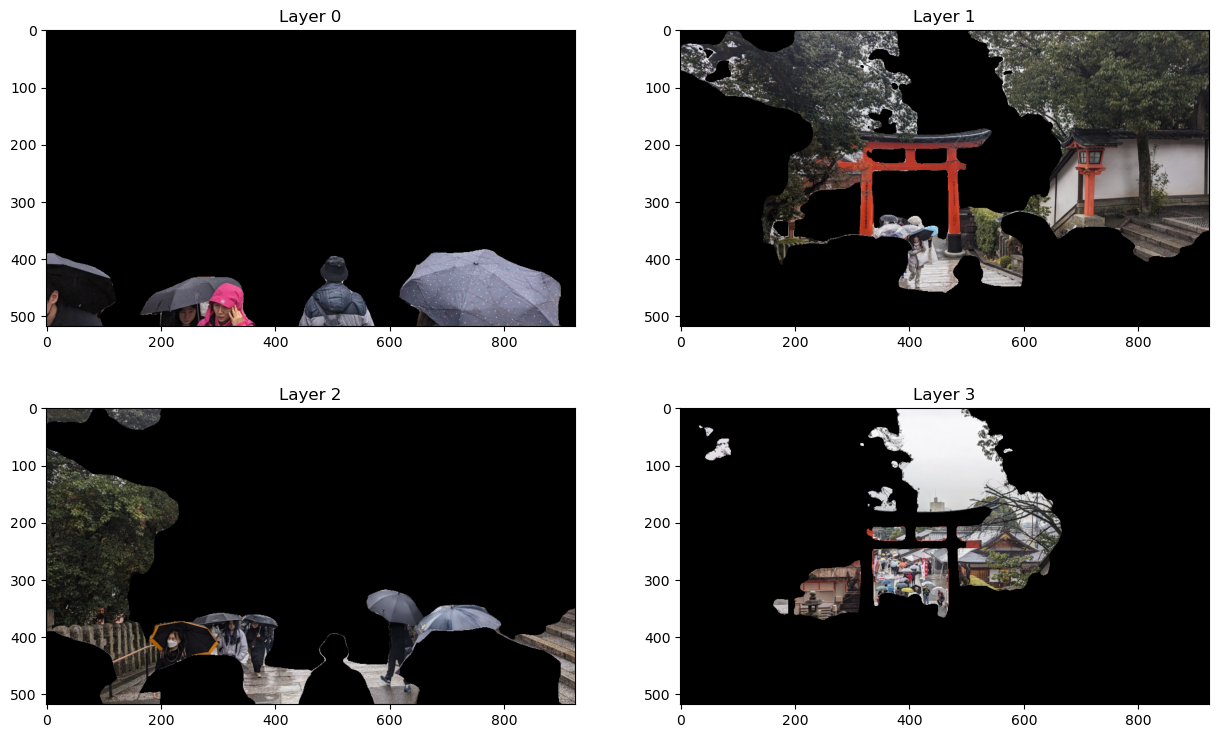

In [37]:
layer_ids = np.unique(d_avgs_kmeans)
# layer_ids = np.unique(res)
img_masks = np.array([(res == i) for i in layer_ids])
img_layers = np.zeros((4, n, m, 3))

print(img_masks.shape)
for i, mk in enumerate(img_masks):
    img_layers[i,mk] = rescaled_img[mk]

plt.figure(figsize=(15,9))

plt.subplot(221)
plt.title('Layer 0')
plt.imshow(img_layers[1,:,:])

plt.subplot(222)
plt.title('Layer 1')
plt.imshow(img_layers[3,:,:])

plt.subplot(223)
plt.title('Layer 2')
plt.imshow(img_layers[0,:,:])

plt.subplot(224)
plt.title('Layer 3')
plt.imshow(img_layers[2,:,:])

this result is only slightly better than just using k-means directly on the depth map. It does a bit of a better job of keeping blocks of content on the same layer however we are still not using RGB values to segment the image...

Some things to consider:
- bright objects like the torii gate in the center of the image are dominant enough to maybe even deserve its own layer even though the depth estimate does not consider it far enough from the trees
- I wonder how well this will perform on things like anime screenshots...